Setting up AI model...
Using device: cpu
Model 'wkcn/TinyCLIP-ViT-39M-16-Text-19M-YFCC15M' loaded and ready.

Processing image: C:\Users\ogw\Downloads\fox3.png


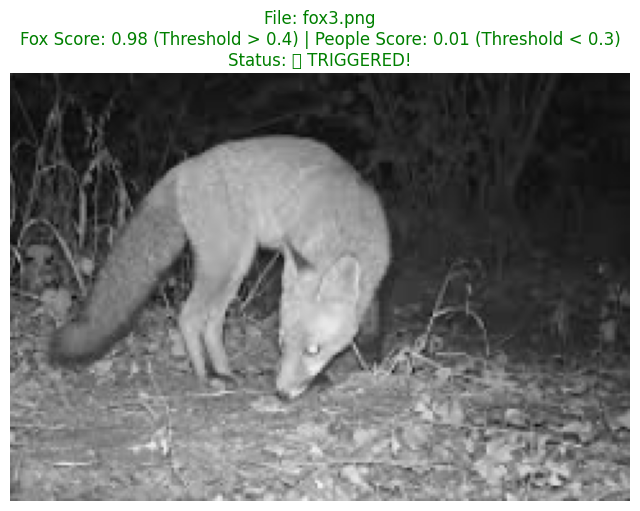

Finished.
man 0.0032231230288743973
woman 0.0022247345186769962
a person walking 0.0001249593769898638
a photograph of a person 0.001214754069224
people 0.00029321256442926824
person wearing a jumper 1.539508048153948e-05
a photograph of a fox 0.9761368632316589
a photograph of a frog 0.0005755937309004366
an empty garden at night 0.0002334886958124116
a car 0.00037922096089459956
grass 0.000539049506187439
empty 0.001487317611463368
nothing 0.00038565375143662095
plants 0.00015743167023174465
blurry image of nothing 0.0008473704801872373
a photograph of a cat 0.0065383403562009335
field 0.0013554017059504986
farm 0.0020464411936700344
desert 0.0009195944294333458
a blurry shadow moving on the ground 0.0006642776424996555
a blurry shape moving quickly 0.0002621641324367374
an alien 0.00013060183846391737
overexposed image of a person walking 0.00019953241280745715
a garden chair 1.4787960935791489e-05
photograph of a metal chair 3.060200469917618e-05


In [27]:
# ==============================================================================
# 1. IMPORTS AND INITIAL SETUP
# ==============================================================================
import os, cv2, time, numpy as np
from collections import deque
from datetime import datetime
from IPython.display import display, Image as IPyImage
import threading
from queue import Queue
import socket
import threading
from queue import Queue

import matplotlib.pyplot as plt



import socket
import threading
from queue import Queue
import time


from PIL import Image
import cv2

import hid
import time

import torch
from transformers import CLIPModel, CLIPProcessor
# ==============================================================================
# 2. TINYCLIP MODEL SETUP
# ==============================================================================
# --- Configuration ---
MODEL_ID = "wkcn/TinyCLIP-ViT-8M-16-Text-3M-YFCC15M"
MODEL_ID = "wkcn/TinyCLIP-ViT-61M-32-Text-29M-LAION400M"
MODEL_ID = "wkcn/TinyCLIP-ViT-39M-16-Text-19M-YFCC15M"

# --- Device Selection ---
print("Setting up AI model...")
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

# --- Load Model and Processor ---
processor = CLIPProcessor.from_pretrained(MODEL_ID)
model = CLIPModel.from_pretrained(MODEL_ID)
model.to(DEVICE)
model.eval()
print(f"Model '{MODEL_ID}' loaded and ready.")

# ==============================================================================
# 3. DETECTION ALGORITHM CONFIGURATION
# ==============================================================================
# --- Prompts ---
n_people_decoys = 6
PROMPTS = [
    "man", "woman", "a person walking", "a photograph of a person",
    "people", "person wearing a jumper", "a photograph of a fox",
    "a photograph of a frog", "an empty garden at night", "a car", 'grass', 'empty', 'nothing', 'plants',
    'blurry image of nothing', 'a photograph of a cat', 'field', 'farm', 'desert',
    "a blurry shadow moving on the ground", "a blurry shape moving quickly", "an alien",
    "overexposed image of a person walking", "a garden chair", "photograph of a metal chair"
]
FOX_PROMPT_INDEX = PROMPTS.index("a photograph of a fox")

# --- Thresholds ---
FOX_SCORE_THRESHOLD = 0.40
PEOPLE_SUM_THRESHOLD = 0.30

# ==============================================================================
# 4. HELPER FUNCTIONS
# ==============================================================================
def find_top_matching_prompts(image_path, candidate_prompts, top_k=5):
    """
    Given an image path and a list of candidate prompts,
    returns the top_k prompts that the model thinks match the image.
    """
    image_frame = cv2.imread(image_path)
    if image_frame is None:
        raise ValueError(f"Could not read image at {image_path}")

    # Get model probabilities for all candidate prompts
    probabilities = score_image_against_prompts(image_frame, candidate_prompts)
    
    # Get top K prompts
    top_indices = np.argsort(probabilities)[::-1][:top_k]
    top_prompts = [(candidate_prompts[i], probabilities[i]) for i in top_indices]
    
    return top_prompts


def score_image_against_prompts(image_frame, prompts):
    """Scores an image (NumPy array) against a list of text prompts."""
    rgb_frame = cv2.cvtColor(image_frame, cv2.COLOR_BGR2RGB)
    image = Image.fromarray(rgb_frame)
    
    inputs = processor(text=prompts, images=image, return_tensors="pt", padding=True)
    inputs = {k: v.to(DEVICE) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        logits_per_image = outputs.logits_per_image
        probs = logits_per_image.softmax(dim=1).squeeze().cpu().numpy()
        
    return probs

def display_image_with_results(image_frame, file_path, fox_score, people_score, is_triggered):
    """Displays the image inline with its scores and trigger status in the title."""
    rgb_image = cv2.cvtColor(image_frame, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(8, 8))
    
    status_text = "✅ TRIGGERED!" if is_triggered else "❌ NOT TRIGGERED"
    title_color = 'green' if is_triggered else 'red'
    
    title = (
        f"File: {os.path.basename(file_path)}\n"
        f"Fox Score: {fox_score:.2f} (Threshold > {FOX_SCORE_THRESHOLD}) | "
        f"People Score: {people_score:.2f} (Threshold < {PEOPLE_SUM_THRESHOLD})\n"
        f"Status: {status_text}"
    )
    
    plt.imshow(rgb_image)
    plt.title(title, color=title_color, fontsize=12)
    plt.axis('off')
    plt.show()

# ==============================================================================
# 5. MAIN EXECUTION LOGIC
# ==============================================================================
def test_single_image(image_path):
    """
    Loads a single image and runs the fox detection algorithm on it.
    """
    print(f"\nProcessing image: {image_path}\n" + "="*50)
    
    if not os.path.exists(image_path):
        print(f"⚠️ ERROR: The file was not found at '{image_path}'. Please check the path.")
        return

    image_frame = cv2.imread(image_path)
    if image_frame is None:
        print(f"Could not read the image file. Please check if it's a valid image.")
        return

    # Get the probability scores from the model.
    probabilities = score_image_against_prompts(image_frame, PROMPTS)
    
    # Extract the specific scores for the algorithm.
    fox_score = probabilities[FOX_PROMPT_INDEX]
    people_scores_sum = np.sum(probabilities[:n_people_decoys])
    
    # Determine if the trigger conditions are met.
    is_triggered = (fox_score > FOX_SCORE_THRESHOLD and 
                    people_scores_sum < PEOPLE_SUM_THRESHOLD)
    
    # Display the image and the results.
    display_image_with_results(image_frame, image_path, fox_score, people_scores_sum, is_triggered)
    
    print("="*50 + "\nFinished.")

    for thing, prob in zip(PROMPTS, probabilities):
        print(f"{thing} {prob}")

# ==============================================================================
# 6. RUN THE TEST
# ==============================================================================
if __name__ == '__main__':
    # --- IMPORTANT: EDIT THIS PATH ---
    # Point this to the single image file you want to test.
    # 🦊 EXAMPLE for Windows: IMAGE_PATH_TO_TEST = r"C:\Users\YourUsername\Desktop\fox.jpg"
    # 🦊 EXAMPLE for Mac/Linux: IMAGE_PATH_TO_TEST = "/home/your_username/pictures/fox.jpg"
    
    IMAGE_PATH_TO_TEST = r"C:\Users\ogw\Documents\GitHub\fox_streamlined\motion_events\20251004_191737_506\fox_detected_0.579.jpg"
    IMAGE_PATH_TO_TEST = r"C:\Users\ogw\Downloads\fox3.png"
    
    test_single_image(IMAGE_PATH_TO_TEST)

In [13]:
CANDIDATE_PROMPTS = [
    # --- Other Animals & Creatures ---
    'a photograph of a cat prowling at night',
    'a black cat slinking across the grass',
    'a ginger cat sitting on a fence',
    'a neighbor\'s dog sniffing the ground',
    'a badger foraging for food',
    'a hedgehog scurrying on the lawn',
    'a squirrel running along a wall',
    'a mouse or rat moving quickly',
    'a bird landing on the ground',
    'a slug or snail on the pavement',
    'an insect crawling on the camera lens',
    'a spiderweb covered in dew',

    # --- Environmental & Natural Movement ---
    'a bush swaying in the wind',
    'leaves rustling on the ground',
    'the shadow of a tree branch moving',
    'a long blade of grass blowing in front of the camera',
    'a plastic bag or litter blowing past',
    'a tumbleweed of dry leaves',
    'a plant pot falling over',

    # --- Weather & Lighting Effects ---
    'raindrops on the camera lens',
    'heavy rain falling',
    'a puddle reflecting a light',
    'lens flare from a security light',
    'dense fog or mist',
    'steam rising from the ground on a cold night',
    'a bright, overexposed object in infrared',
    'sunlight filtering through trees at dawn',

    # --- Inanimate & Man-Made Objects ---
    'a garden hose lying on the grass',
    'a child\'s toy left outside',
    'a discarded newspaper or piece of cardboard',
    'a garden gnome or statue',
    'a watering can',
    'a person\'s shoe or boot',

    # --- Abstract & Camera-Related ---
    'a blurry shape moving quickly',
    'an out-of-focus image',
    'digital noise in a low-light video',
    'a fast-moving dark object',
    'a light-colored blob',
    'an empty garden with nothing happening',
    'a clear view of the patio at night',
    'a still image of an empty lawn',
]

top_matches = find_top_matching_prompts(IMAGE_PATH_TO_TEST, CANDIDATE_PROMPTS, top_k=5)
print("Top matching prompts for this false positive:")
for prompt, score in top_matches:
    print(f"{prompt}: {score:.3f}")

Top matching prompts for this false positive:
a photograph of a cat prowling at night: 0.295
a bright, overexposed object in infrared: 0.294
a blurry shape moving quickly: 0.039
a neighbor's dog sniffing the ground: 0.036
an out-of-focus image: 0.032
